In [1]:
# !pip install seaborn sklearn

import pandas as pd
import numpy as np
from collections import namedtuple
import tensorflow as tf
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report
import keras

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
reviews_file = "/home/ec2-user/reviews.json.gz"

import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for json_review in parse(path):
        df[i] = json_review
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF(reviews_file)

In [3]:
df.head(3)

reviewerID        asin     reviewerName   helpful  \
0   AO94DHGC771SJ  0528881469          amazdnu    [0, 0]   
1   AMO214LNFCEI4  0528881469  Amazon Customer  [12, 15]   
2  A3N7T0DY83Y4IG  0528881469    C. A. Freeman  [43, 45]   

                                          reviewText  overall  \
0  We got this GPS for my husband who is an (OTR)...      5.0   
1  I'm a professional OTR truck driver, and I bou...      1.0   
2  Well, what can I say.  I've had this unit in m...      3.0   

             summary  unixReviewTime   reviewTime  
0    Gotta have GPS!      1370131200   06 2, 2013  
1  Very Disappointed      1290643200  11 25, 2010  
2     1st impression      1283990400   09 9, 2010

In [4]:
print("Total number of reviews in a data set:",len(df))

Total number of reviews in a data set: 1689188


Score distribution


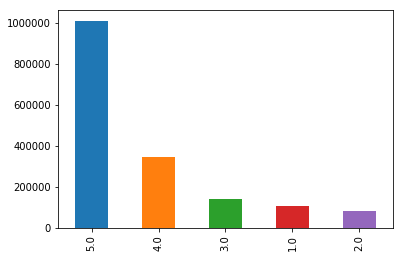

In [5]:
print("Score distribution")
df['overall'].value_counts().plot(kind="bar")

In [6]:
print("Average Score of the reviews: ",np.mean(df.overall))
print("Median Score of the reviews: ",np.median(df.overall))

Average Score of the reviews:  4.222779228836577
Median Score of the reviews:  5.0


In [7]:
df.loc[df.overall>3,'Sentiment']="POSITIVE"
df.loc[df.overall<3,'Sentiment']="NEGATIVE"

In [8]:
df.head(3)

reviewerID        asin     reviewerName   helpful  \
0   AO94DHGC771SJ  0528881469          amazdnu    [0, 0]   
1   AMO214LNFCEI4  0528881469  Amazon Customer  [12, 15]   
2  A3N7T0DY83Y4IG  0528881469    C. A. Freeman  [43, 45]   

                                          reviewText  overall  \
0  We got this GPS for my husband who is an (OTR)...      5.0   
1  I'm a professional OTR truck driver, and I bou...      1.0   
2  Well, what can I say.  I've had this unit in m...      3.0   

             summary  unixReviewTime   reviewTime Sentiment  
0    Gotta have GPS!      1370131200   06 2, 2013  POSITIVE  
1  Very Disappointed      1290643200  11 25, 2010  NEGATIVE  
2     1st impression      1283990400   09 9, 2010       NaN

In [9]:
import warnings
warnings.filterwarnings("ignore")
ax = plt.axes()
sns.countplot(df.Sentiment,ax=ax)
ax.set_title('Sentiment Distribution: Positive vs. Negative')

Text(0.5,1,'Sentiment Distribution: Positive vs. Negative')

In [10]:
positive = (df[df.Sentiment=="POSITIVE"])
negative = (df[df.Sentiment =="NEGATIVE"])
#smallpositive = positive.sample(n=150000)
#smallnegative = negative.sample(n=150000)
smallpositive = positive.sample(n=10000)
smallnegative = negative.sample(n=10000)

datamixed = [smallpositive, smallnegative]
data = pd.concat(datamixed)

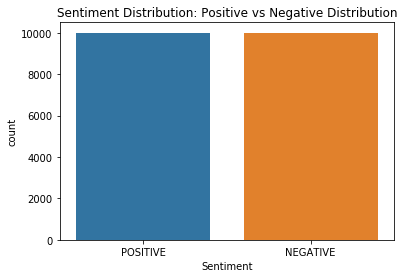

In [11]:
ax = plt.axes()
sns.countplot(data.Sentiment,ax=ax)
ax.set_title('Sentiment Distribution: Positive vs Negative Distribution')
plt.show()

In [12]:
reviews = data.reviewText.values
labels = np.array([1 if s=="POSITIVE"  else 0 for s in data.Sentiment.values])

In [13]:
reviews_cleaned = []
for i in range(len(reviews)):
    reviews_cleaned.append(''.join([c.lower() for c in reviews[i] if c not in punctuation]))

In [14]:
print("BEFORE: ",reviews[7])
print("********************")
print("AFTER: ",reviews_cleaned[7])

BEFORE:  This monitor is incredibly sharp, bright, clear. It is like a glass, and it is also glossy so I can see my reflection exactly like I would in a glass window, for example. That does not disturb me since the color that it produces is perfect.I bought this monitor as an upgrade to my old Samsung LCD 22&#34;, I wanted to buy a 1440p monitor but was way expensive for my budget and then I saw this one probably on sale here at Amazon and decided to give it a try.It arrived in perfect shape, not a single scratch. It comes with a VGA and a DVI-S Connector. Installation was the easiest thing in the world, just mounted the two parts that makes the base, connect to the electricity and to the DVI in my Video Card and that was it, it was rocking.I see no dead pixels, when in dark scenes it is really dark, white is white indeed.I played a 1080p movie and looked awesome, then I tried a videogame.I played Bioshock that I got just a month ago in a sale on Steam. This monitor has I think an 8ms 

In [15]:
vocabulary = set(' '.join(reviews_cleaned).split())
print("Vocabulary size: ", len(vocabulary))

Vocabulary size:  70462


In [16]:
from collections import Counter

def vocabulary_reduction(reviews,min_freq=0,polarity_cut_off=0.1):
    
    pos_count = Counter()
    neg_count = Counter()
    tot_count = Counter()

    for i in range(len(reviews)):
        for word in reviews[i].split():
            tot_count[word]+=1
            if labels[i] == 1:
                pos_count[word]+=1
            else:
                neg_count[word]+=1    
    
    #Identify words with frequency greater than min_freq
    vocab_freq = []
    for word in tot_count.keys():
        if tot_count[word]>min_freq:
            vocab_freq.append(word)  
    
    #Use polarity to reduce vocab
    pos_neg_ratio = Counter()
    vocab_pos_neg = (set(pos_count.keys())).intersection(set(neg_count.keys()))
    for word in vocab_pos_neg:
        if tot_count[word]>100:
            ratio = pos_count[word]/float(neg_count[word]+1)
            if ratio>1:
                pos_neg_ratio[word] = np.log(ratio)
            else:
                pos_neg_ratio[word] = -np.log(1/(ratio+0.01)) 
    
    mean_ratio = np.mean(list(pos_neg_ratio.values()))
    
    vocab_polarity = []
    for word in pos_neg_ratio.keys():
        if (pos_neg_ratio[word]<(mean_ratio-polarity_cut_off)) or (pos_neg_ratio[word]>(mean_ratio+polarity_cut_off)):
            vocab_polarity.append(word)
     
    vocab_rm_polarity = set(pos_neg_ratio.keys()).difference(vocab_polarity)
    vocab_reduced = (set(vocab_freq)).difference(set(vocab_rm_polarity))
 
    reviews_cleaned = []
    
    for review in reviews:
        review_temp = [word for word in review.split() if word in vocab_reduced]
        reviews_cleaned.append(' '.join(review_temp))
    
    return reviews_cleaned

In [17]:
reviews_cleaned_reduced = vocabulary_reduction(reviews_cleaned, min_freq=10,polarity_cut_off=0.1)

In [18]:
# Store all the text from each review in a text variable
text = ' '.join(reviews_cleaned_reduced)

# List all the vocabulary contained in the reviews
vocabulary = set(text.split(' '))

print(len(vocabulary))

# Map each word to an integer
vocabulary_to_int = {word:i for i,word in enumerate(vocabulary,0)}
print(list(vocabulary)[:50])

7124
['', 'consists', 'boards', 'suffers', '15tb', 'eager', 'bat', 'approved', 'bought', 'dropping', 'they', 'vga', 'pretty', 'earned', 'emptor', 'unnecessary', 'guests', 'notes', 'eating', 'severe', 'mounting', 'rolled', 'yard', 'adaptor', 'blurring', 'oriented', 'easyshare', 't', 'ease', 'soldering', 'tighten', 'lacked', 'looks', 'heres', 'fn', 'require', 'solved', 'measuring', 'tech', 'tend', 'outweigh', 'walked', 'signed', 'cowboy', 'actively', 'functioned', 'characters', 'lifting', 'midrange', 'e']


In [19]:
def reviews_to_integers(reviews):
    reviews_to_int = []
    for i in range(len(reviews)):
        to_int = [vocabulary_to_int[word] for word in reviews[i].split()]
        reviews_to_int.append(to_int)
    return reviews_to_int

reviews_to_int = reviews_to_integers(reviews_cleaned_reduced)

In [20]:
review_lengths = [len(review) for review in reviews_to_int]
print("Shortest review:", min(review_lengths))
print("Longest revies:",max(review_lengths))

Shortest review: 0
Longest revies: 2186


[]

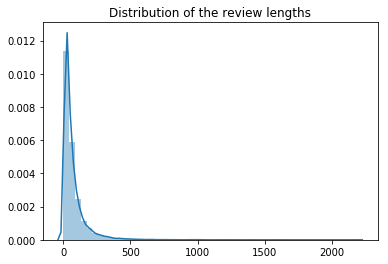

In [21]:
ax = plt.axes()
sns.distplot(review_lengths)
ax.set_title("Distribution of the review lengths")
plt.plot()

In [22]:
pd.DataFrame(review_lengths).describe()

0
count  20000.000000
mean      73.424050
std       91.816384
min        0.000000
25%       23.000000
50%       44.000000
75%       86.000000
max     2186.000000

In [23]:
max_length = 200
features = np.zeros(shape=(len(reviews_to_int),max_length),dtype=int)

In [24]:
for i in range(len(reviews_to_int)):
    nb_words = len(reviews_to_int[i])
    features[i] = [0]*(max_length -nb_words) + reviews_to_int[i][:max_length]

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split

In [26]:
X = features
Y = pd.get_dummies(data['Sentiment']).values

In [27]:
#Checkpoint
np.savez("reviews_checkpoint_20k.npz", vocabulary_size=np.array([len(vocabulary)]),X=X,Y=Y)

In [28]:
#Continue from here with data pre-processed
npzfile = np.load("reviews_checkpoint_20k.npz")
X=npzfile['X']
Y=npzfile['Y']
vocabulary_size=npzfile['vocabulary_size'][0]
#print(vocabulary_size)
#print(X[:3])
#print(Y[:3])

In [29]:
embed_dim = 50
lstm_out = 80
model = Sequential()
model.add(Embedding(vocabulary_size, embed_dim, input_length=X.shape[1], dropout=0.2, name='embedding'))
model.add(LSTM(lstm_out, dropout_U=0.2, dropout_W=0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           356200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 80)                41920     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 162       
Total params: 398,282
Trainable params: 398,282
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(16000, 200) (16000, 2)
(4000, 200) (4000, 2)


In [31]:
#run the following line in your terminal
#tensorboard --logdir ./tf_logs

In [32]:
batch_size = 32
epochs = 5

tbCallback = keras.callbacks.TensorBoard(
    log_dir='./tf_logs', 
    histogram_freq=0, 
    batch_size=batch_size, 
    write_graph=True, 
    write_grads=False, 
    write_images=False, 
    embeddings_freq=0,
    embeddings_layer_names=['embedding'], embeddings_metadata=None)

model.fit(X_train, Y_train, 
          nb_epoch = epochs, 
          batch_size=batch_size, 
          verbose = 1, 
          validation_data=(X_test, Y_test), 
          callbacks=[tbCallback])

Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 174s 11ms/step - loss: 0.4590 - acc: 0.7821 - val_loss: 0.3572 - val_acc: 0.8450
Epoch 2/5
16000/16000 [==============================] - 173s 11ms/step - loss: 0.3050 - acc: 0.8769 - val_loss: 0.3944 - val_acc: 0.8540
Epoch 3/5
16000/16000 [==============================] - 172s 11ms/step - loss: 0.2512 - acc: 0.9042 - val_loss: 0.3805 - val_acc: 0.8502
Epoch 4/5
16000/16000 [==============================] - 173s 11ms/step - loss: 0.2075 - acc: 0.9205 - val_loss: 0.3936 - val_acc: 0.8460
Epoch 5/5
16000/16000 [==============================] - 172s 11ms/step - loss: 0.1732 - acc: 0.9364 - val_loss: 0.4339 - val_acc: 0.8438


In [33]:
model.save("trained_model_20k_5epochs_1gpu")
del model

In [34]:
from keras.models import load_model
model = load_model('trained_model_20k_5epochs_1gpu')

In [35]:
validation_size = 100
validation_2_size = 100
validation_3_size = 100

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]

X_validate_2 = X_test[-validation_2_size:]
Y_validate_2 = Y_test[-validation_2_size:]
X_test = X_test[:-validation_2_size]
Y_test = Y_test[:-validation_2_size]

X_validate_3 = X_test[-validation_3_size:]
Y_validate_3 = Y_test[-validation_3_size:]
X_test = X_test[:-validation_3_size]
Y_test = Y_test[:-validation_3_size]

score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))


score: 0.43
acc: 0.84


In [36]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 79.62962962962963 %
neg_acc 89.13043478260869 %
